In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D

import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random
import copy
import math
import os
import argparse

from google.colab import drive


class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.avg = 0
        self.sum = 0
        self.cnt = 0

    def update(self, val, n=1):
        self.sum += val * n
        self.cnt += n
        self.avg = self.sum / self.cnt


In [5]:
# train_transform = transforms.Compose([transforms.ToTensor(), transforms.Pad(padding=(2, 2, 2, 2), fill=0.)])
# test_transform = transforms.Compose([transforms.ToTensor(), transforms.Pad(padding=(2, 2, 2, 2), fill=0.)])

# train_dataset = datasets.MNIST(root='../data', train=True, download=True, transform=train_transform)
# test_dataset = datasets.MNIST(root='../data', train=False, download=True, transform=test_transform)


train_transform = transforms.Compose([transforms.RandomHorizontalFlip(), transforms.ToTensor()])
test_transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.CIFAR10(root='../data', train=True, download=True, transform=train_transform)
test_dataset = datasets.CIFAR10(root='../data', train=False, download=True, transform=test_transform)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
def get_timestep_embedding(timesteps, embedding_dim, max_positions=10000):
    assert len(timesteps.shape) == 1

    half_dim = embedding_dim // 2
    emb = math.log(max_positions) / (half_dim - 1)

    emb = torch.exp(torch.arange(half_dim, dtype=torch.float32, device=timesteps.device) * -emb)

    emb = timesteps.float().unsqueeze(1) * emb.unsqueeze(0)
    emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)

    if embedding_dim % 2 == 1:  # zero pad
        emb = F.pad(emb, (0, 1), mode='constant')

    assert emb.shape == (timesteps.shape[0], embedding_dim)
    return emb


class Upsample(nn.Module):
    def __init__(self, cin, cout=None):
        super().__init__()
        cout = cin if cout is None else cout
        self.conv = nn.Conv2d(cin, cout, 3, 1, 1)

    def forward(self, x):
        x = F.interpolate(x, scale_factor=2.0, mode="nearest")
        x = self.conv(x)
        return x


class Downsample(nn.Module):
    def __init__(self, cin, cout=None):
        super().__init__()
        cout = cin if cout is None else cout
        self.conv = nn.Conv2d(cin, cout, 3, 2, 0)

    def forward(self, x):
        x = F.pad(x, (0, 1, 0, 1), mode="constant", value=0)
        x = self.conv(x)
        return x




In [7]:
class ResBlock(nn.Module):
    def __init__(self, in_ch, out_ch, temb_dim=None):
        super().__init__()
        self.net1 = nn.Sequential(nn.GroupNorm(num_groups=32, num_channels=in_ch, eps=1e-6),
                                  nn.ELU(),
                                  nn.Conv2d(in_ch, out_ch, 3, 1, 1))

        self.temb = None

        if temb_dim is not None:
            self.temb = nn.Linear(temb_dim, out_ch)
        
        self.net2 = nn.Sequential(nn.GroupNorm(num_groups=32, num_channels=out_ch, eps=1e-6),
                                  nn.ELU(),
                                  nn.Dropout(p=0.1),
                                  nn.Conv2d(out_ch, out_ch, 3, 1, 1))

        self.shortcut = None
        if in_ch != out_ch:
            self.shortcut = nn.Conv2d(in_ch, out_ch, 1, 1, 0)

    def forward(self, x, temb=None):
        
        h = self.net1(x)
        
        if temb is not None:
            h = h + self.temb(temb).unflatten(-1, (-1, 1, 1))
        
        h = self.net2(h)
        
        if self.shortcut is not None:
            x = self.shortcut(x)

        return x + h


class AttnBlock(nn.Module): # channel-wise attention
    def __init__(self, channels):
        super().__init__()
        self.channels = channels
        self.group_norm = nn.GroupNorm(32, channels)
        self.proj = nn.Conv2d(channels, 3 * channels, 1, 1, 0)
        self.output = nn.Conv2d(channels, channels, 1, 1, 0)

    def forward(self, x):
        h = self.group_norm(x)
        q, k, v = self.proj(h).chunk(3, dim=1)
        q = q.permute(0, 2, 3, 1).flatten(1, -2)
        k = k.flatten(-2, -1)
        w = torch.bmm(q, k) / np.sqrt(self.channels)        
        w = w.softmax(dim=1)  # [b, hw, hw] 
        v = v.flatten(-2, -1)
        h = torch.bmm(v, w)
        h = h.unflatten(-1, (x.size()[2], x.size()[3]))
        h = self.output(h)
        return x + h


def get_diffusion_coeffs(beta1, betaT, num_time_steps):
    beta = torch.linspace(beta1, betaT, num_time_steps)
    beta = F.pad(beta, (1, 0), value=0.)
    alpha = torch.cumprod(1. - beta, dim=-1) # bar{alpha} in ddpm paper
    return alpha, beta


class Diffuser(object):
    def __init__(self, beta1, betaT, num_timesteps):
        self.num_timesteps = num_timesteps
        self.alpha, self.beta = get_diffusion_coeffs(beta1, betaT, num_timesteps)

    def forward(self, x0, t, noise=None): # x{0} -> x{t}
        if noise is None:
            noise = torch.randn_like(x0)

        if torch.is_tensor(t):
            t = t.to(x0.device)

        alpha = self.alpha.to(x0.device)
        alpha = alpha.unflatten(-1, (-1, *[1 for d in x0.size()[1:]]))
        xt = alpha[t].sqrt() * x0 + (1. - alpha[t]).sqrt() * noise
        return xt, noise

    def sample_time(self, batch_size):
        return torch.randint(low=1, high=self.num_timesteps + 1, size=(batch_size, ))
    
    @torch.no_grad()
    def reverse_process(self, xT, net, get_xts=False, get_x0s=False):
        time = torch.zeros(xT.size()[0], dtype=torch.long).to(xT.device)
        alpha = self.alpha.to(xT.device)
        beta = self.beta.to(xT.device)
        xt = xT

        xt_chain = [] if get_xts else None
        x0_chain = [] if get_x0s else None
        x0 = None
        for t in reversed(range(1, self.num_timesteps + 1)):
            
            time.fill_(t)
            
            beta_t = beta[t]
            alpha_t = alpha[t]
            alpha_t_minus = alpha_t / (1. - beta_t)
            
            sigma = torch.sqrt(beta_t * (1. - alpha_t_minus) / (1. - alpha_t))
            xt_coeff = torch.sqrt(1. / (1. - beta_t))
            noise_coeff = - torch.sqrt(1. / (1. - beta_t)) * beta_t / torch.sqrt(1. - alpha_t)
            noise_pred = net(xt, time)
            
            x0_pred = torch.sqrt(1. / alpha_t) * (xt - torch.sqrt(1. - alpha_t) * noise_pred)
            if t == 1:
                x0 = x0_pred

            xt = xt_coeff * xt + noise_coeff * noise_pred + sigma * torch.randn_like(xt)
  
            if xt_chain is not None:
                xt_chain.append(xt)
            
            if x0_chain is not None:
                x0_chain.append(x0_pred)

        return x0, xt_chain, x0_chain


In [8]:
class UNet(nn.Module):
    def __init__(self, args):
        super().__init__()

        ch = args.channels
        ch_mults = args.channel_mults
        use_attn = args.use_attention
        num_levels = len(ch_mults)
        num_res_blocks = args.num_res_blocks
        time_embedding_size = args.time_embedding_size

        self.channels = ch
        self.time_embedding_size = time_embedding_size
        self.input_conv = nn.Conv2d(args.input_channels, ch, 3, 1, 1)
        self.time_embed = [nn.Linear(ch, time_embedding_size), nn.ELU(), nn.Linear(time_embedding_size, time_embedding_size)]
        self.time_embed = nn.Sequential(*self.time_embed)

        enc_tower = []

        prev_ch = ch
        for l in range(num_levels):
            level_ch = ch_mults[l] * ch
            for i in range(num_res_blocks[l]):
                resnet = None

                if i == 0:
                    resnet = ResBlock(prev_ch, level_ch, time_embedding_size)

                else:
                    resnet = ResBlock(level_ch, level_ch, time_embedding_size)

                enc_tower += [resnet]

                if use_attn[l]:
                    enc_tower += [AttnBlock(level_ch)]

            if l < num_levels - 1:
                enc_tower += [Downsample(level_ch)]

            prev_ch = level_ch

        self.enc_tower = nn.ModuleList(enc_tower)
        
        mid_ch = ch * ch_mults[-1]
        self.mid_block = [ResBlock(mid_ch, mid_ch), AttnBlock(mid_ch), ResBlock(mid_ch, mid_ch)]
        self.mid_block = nn.Sequential(*self.mid_block)
        dec_tower = []


        for l in range(num_levels)[::-1]:
            level_ch = ch_mults[l] * ch

            for i in range(num_res_blocks[l]):
                
                resnet = ResBlock(level_ch + level_ch, level_ch, time_embedding_size)
                
                dec_tower += [resnet]
                if use_attn[l]:
                    dec_tower += [AttnBlock(level_ch)]
            
            up_module = []

            if l == 0:
                up_module += [ResBlock(level_ch, ch)]

            else:
                up_module += [ResBlock(level_ch, ch_mults[l - 1] * ch), Upsample(ch_mults[l - 1] * ch)]
            
            dec_tower += [nn.Sequential(*up_module)]

        self.dec_tower = nn.ModuleList(dec_tower)

        self.output_conv = nn.Sequential(nn.ELU(), nn.Conv2d(ch, args.input_channels, 1, 1, 0))


    def forward(self, x, t):
        
        temb = self.time_embed(get_timestep_embedding(t, self.channels)).to(x.device)
        
        hs = []
        h = self.input_conv(x)
        for module in self.enc_tower:
            if isinstance(module, ResBlock):
                h = module(h, temb)
                hs.append(h)

            else:
                h = module(h)
                
        h = self.mid_block(h)
        for module in self.dec_tower:
            if isinstance(module, ResBlock):
                h = torch.cat([h, hs.pop()], dim=1)
                h = module(h, temb)

            else:
                h = module(h)

        out = self.output_conv(h)
        return out

In [9]:
args = argparse.Namespace()

args.channels = 128
args.channel_mults = [1, 2, 2, 2]
args.use_attention = [False, False, False, False]
args.num_res_blocks = [4, 4, 4, 4]
args.time_embedding_size = args.channels * 4
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'
args.learning_rate = 1e-4
args.batch_size = 128
args.num_epochs = 100
args.input_channels = 3
args.num_timesteps = 1000
args.beta1 = 1e-4
args.betaT = 0.02

In [10]:
model = UNet(args).to(args.device)
diffuser = Diffuser(args.beta1, args.betaT, args.num_timesteps)
optimizer = optim.Adam(model.parameters(), lr=args.learning_rate)

In [11]:
loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, drop_last=True)
loss_meter = AverageMeter()
for epoch in range(100):
    for x, _ in loader:
        x = x.to(args.device)
        x = 2. * x - 1.
        t = diffuser.sample_time(x.size()[0]).to(args.device)
        optimizer.zero_grad()
        xt, noise = diffuser.forward(x, t)
        noise_pred = model(xt, t)
        loss = (noise - noise_pred).square().mean(dim=0).sum()
        loss.backward()
        optimizer.step()
        loss_meter.update(loss.item())

    print('[epoch %3d] | %s: %7.5f |' % (epoch, 'loss', loss_meter.avg))
    

[epoch   0] | loss: 234.79250 |
[epoch   1] | loss: 188.36906 |
[epoch   2] | loss: 168.46713 |
[epoch   3] | loss: 156.85806 |
[epoch   4] | loss: 149.44198 |
[epoch   5] | loss: 143.71202 |
[epoch   6] | loss: 139.30384 |
[epoch   7] | loss: 135.65245 |
[epoch   8] | loss: 132.76624 |
[epoch   9] | loss: 130.30954 |
[epoch  10] | loss: 128.29201 |
[epoch  11] | loss: 126.40871 |
[epoch  12] | loss: 124.76976 |
[epoch  13] | loss: 123.32948 |
[epoch  14] | loss: 122.11836 |
[epoch  15] | loss: 120.91546 |
[epoch  16] | loss: 119.82794 |
[epoch  17] | loss: 118.78917 |
[epoch  18] | loss: 117.97339 |
[epoch  19] | loss: 117.18375 |
[epoch  20] | loss: 116.41797 |
[epoch  21] | loss: 115.74012 |
[epoch  22] | loss: 115.10647 |
[epoch  23] | loss: 114.53762 |
[epoch  24] | loss: 113.91655 |
[epoch  25] | loss: 113.42089 |
[epoch  26] | loss: 112.90764 |
[epoch  27] | loss: 112.43155 |
[epoch  28] | loss: 111.97846 |
[epoch  29] | loss: 111.55093 |
[epoch  30] | loss: 111.13098 |
[epoch  

KeyboardInterrupt: ignored

In [15]:
loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, drop_last=True)
loss_meter = AverageMeter()
for epoch in range(100):
    for x, _ in loader:
        x = x.to(args.device)
        x = 2. * x - 1.
        t = diffuser.sample_time(x.size()[0]).to(args.device)
        optimizer.zero_grad()

        xt, noise = diffuser.forward(x, t)
        noise_pred = model(xt, t)
        loss = (noise - noise_pred).square().mean(dim=0).sum()
        loss.backward()
        optimizer.step()
        
        loss_meter.update(loss.item())

    print('[epoch %3d] | %s: %7.5f |' % (epoch, 'loss', loss_meter.avg))
    

[epoch   0] | loss: 95.41746 |
[epoch   1] | loss: 96.02160 |
[epoch   2] | loss: 95.89499 |
[epoch   3] | loss: 95.99081 |
[epoch   4] | loss: 95.96557 |
[epoch   5] | loss: 95.98486 |
[epoch   6] | loss: 95.97773 |
[epoch   7] | loss: 96.11644 |
[epoch   8] | loss: 96.09011 |
[epoch   9] | loss: 96.02345 |
[epoch  10] | loss: 95.98374 |
[epoch  11] | loss: 96.04583 |
[epoch  12] | loss: 95.95099 |
[epoch  13] | loss: 95.99977 |
[epoch  14] | loss: 96.00338 |
[epoch  15] | loss: 95.99436 |
[epoch  16] | loss: 95.89575 |
[epoch  17] | loss: 95.84699 |
[epoch  18] | loss: 95.79247 |
[epoch  19] | loss: 95.79150 |
[epoch  20] | loss: 95.81728 |
[epoch  21] | loss: 95.77826 |
[epoch  22] | loss: 95.73419 |
[epoch  23] | loss: 95.73733 |
[epoch  24] | loss: 95.62574 |
[epoch  25] | loss: 95.66481 |
[epoch  26] | loss: 95.61219 |
[epoch  27] | loss: 95.57694 |
[epoch  28] | loss: 95.56686 |
[epoch  29] | loss: 95.54715 |


KeyboardInterrupt: ignored

In [16]:
xT = torch.randn(128, 3, 32, 32).to(args.device)
x0, xts, x0s = diffuser.reverse_process(xT, model, False, False)

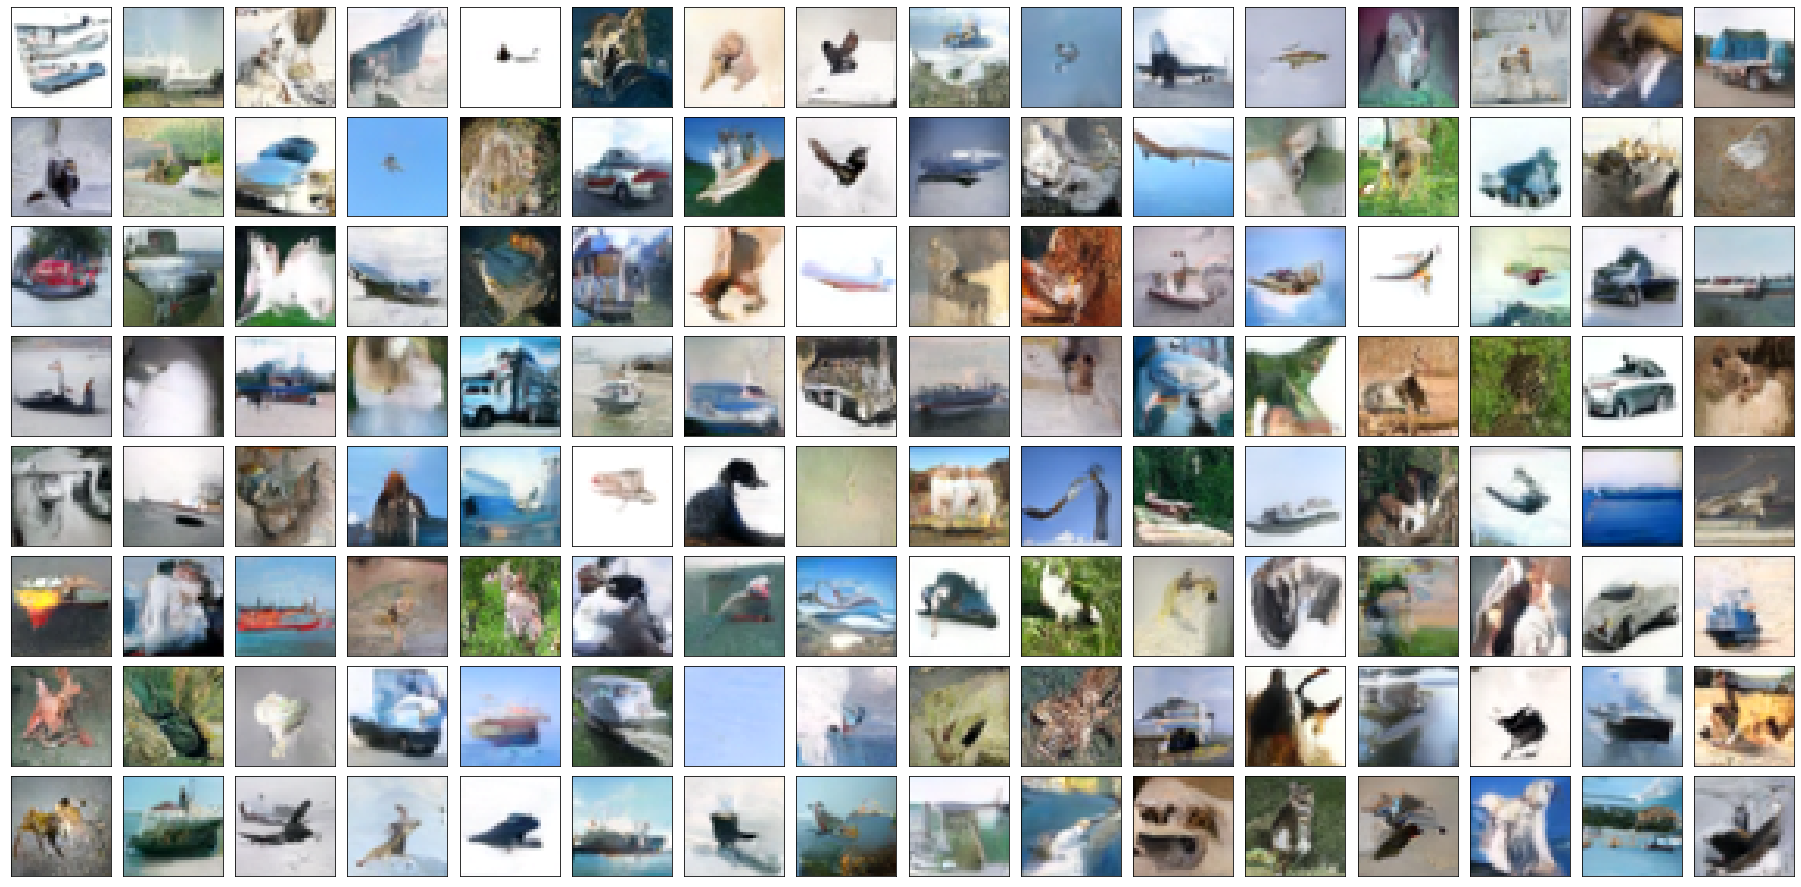

In [17]:
out = x0.clamp(-1, 1).permute(0, 2, 3, 1).detach().cpu().numpy()
out = (out + 1.) * 0.5

fig = plt.figure(figsize=(32, 16))

n = 0

with torch.no_grad():
    for i in range(8 *  16):
        _fig = fig.add_subplot(8, 16, n + 1, xticks=[], yticks=[])
        _fig.imshow(out[i])
        n += 1

plt.subplots_adjust(hspace=0.1, wspace=0.1)
plt.show()